In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score



from src.data import MyDataset, load_data, transform_data
from src.config import  get_model, get_criterion, get_attack
from src.utils import req_grad
from src.estimation.uncertainty import (
    reject_by_metric, 
    get_ensemble_predictive_entropy, 
    get_ensemble_std, 
    get_minprob, 
    reject_randomly,
    reject_by_norm,
    calculate_metrics_class
)

%load_ext autoreload
%autoreload 2

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


# config

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
from hydra import compose, initialize
from omegaconf import OmegaConf

initialize(config_path='../config/my_configs', version_base=None)

cfg = compose(config_name='train_classifier_config.yaml')

In [5]:
device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

# main

## load data

In [6]:
X_train, y_train, X_test, y_test = load_data(cfg["dataset"])
if len(set(y_test)) > 2:
    raise ValueError('Dataset should be binary classfied')
X_train, X_test, y_train, y_test = transform_data(
    X_train,
    X_test,
    y_train,
    y_test,
    slice_data=cfg["slice"],
)

TypeError: unsupported operand type(s) for +: 'DictConfig' and 'str'

In [7]:
test_loader = DataLoader(
    MyDataset(X_test, y_test), batch_size=cfg["batch_size"], shuffle=False
)

## load model

In [8]:
criterion_params = cfg["training_params"]['criterion_params']
if criterion_params == "None" or not criterion_params:
    criterion_params = {}

loss = get_criterion(
    cfg["training_params"]['criterion_name'], 
    criterion_params, 
)

In [9]:
models = []
preds = []
metrics = []
norms = []


for model_id in range(cfg["model_id_start"], cfg["model_id_finish"]):

    base_model = get_model(
        cfg["training_params"]['model_name'], 
        cfg["training_params"]['model_params'], 
        device=device,
        path = os.path.join(cfg['save_path'], f'model_{model_id}_{cfg["dataset"]}.pt'),
        train_mode = False,
        )
    models.append(base_model)

    X_for_pred = X_test.unsqueeze(-1).to(device)
    model_preds = base_model(X_for_pred).cpu().detach().numpy()
    preds.append(model_preds.flatten())
    
    model_metrics = calculate_metrics_class(y_test, np.around(model_preds))
    metrics.append(model_metrics)

    base_model.train()
    req_grad(base_model, state=True)
    X_for_pred.requires_grad = True

    logits = base_model(X_for_pred)
    loss_val = loss(logits, y_test.to(device).float())
    X_for_pred.retain_grad()

    grad = torch.autograd.grad(loss_val, X_for_pred)[0]
    grad_norm = torch.linalg.norm(grad, ord=2, dim=(1,2)).cpu().detach().numpy().tolist()
    norms.append(grad_norm)

    
np_preds = np.array(preds)
ave_preds = np.average(np_preds, axis=0)

norms = np.sum(np.array(norms), axis=0)

## disc model

In [10]:
alpha = None
eps = 0.03
estimator = None

In [11]:
attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = models[0]
attack_params["criterion"] = loss
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader)

100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

torch.Size([128, 235, 1])
torch.Size([128, 235, 1])
torch.Size([114, 235, 1])


In [13]:
X_adv.device

device(type='cpu')

In [14]:
disc_model_cfg = cfg["list_check_model_params"][0]

disc_path = os.path.join(cfg['disc_path'], f"{disc_model_cfg['model_name']}/{disc_model_cfg['model_id']}.pt")

disc_model = get_model(
    cfg["training_params"]['model_name'], 
    cfg["training_params"]['model_params'], 
    device=device,
    path = disc_path,
    train_mode = False,
)

disc_preds = disc_model(X_adv.to(device)).cpu().detach().numpy()

In [15]:
disc_preds.mean()

0.99999166

## uncertainty dict

In [ ]:
rejection_rates = np.linspace(0, 1.0, 20)
iter_to_break = 49
dict_metrics = {
    'Acc':accuracy_score,
    # 'ROC AUC':roc_auc_score,
    # 'PR AUC':average_precision_score
}

dict_curves = dict()
labels = y_test.flatten().float()
labels_disc = np.ones_like(labels)


for metric_name, metric in  dict_metrics.items():
    
    dict_curve_metric = dict()

    
    dict_curve_metric['Pred_entropy_model'] = reject_by_metric(get_ensemble_predictive_entropy,
                                     np_preds,
                                     labels, 
                                     rejection_rates,
                                     metric)


    dict_curve_metric['StD'] = reject_by_metric(get_ensemble_std,
                                np_preds,
                                labels, 
                                rejection_rates,
                                metric)
    
    dict_curve_metric['MaxProb_model'] = reject_by_metric(get_minprob,
                                np_preds[0].reshape(1, -1),
                                labels, 
                                rejection_rates,
                                metric)
    
    dict_curve_metric['MaxProb_disc'] = reject_by_metric(get_minprob,
                                disc_preds,
                                labels_disc, 
                                rejection_rates,
                                metric)
    
    dict_curve_metric['Random'] = reject_randomly(ave_preds,
                                  labels, 
                                  rejection_rates,
                                  1000,
                                  metric)
    
    dict_curve_metric['Grad_Norm'] = reject_by_norm(norms.flatten(),
                                np_preds,
                                labels, 
                                rejection_rates,
                                metric)  
    
    
    dict_curves[metric_name] = dict_curve_metric

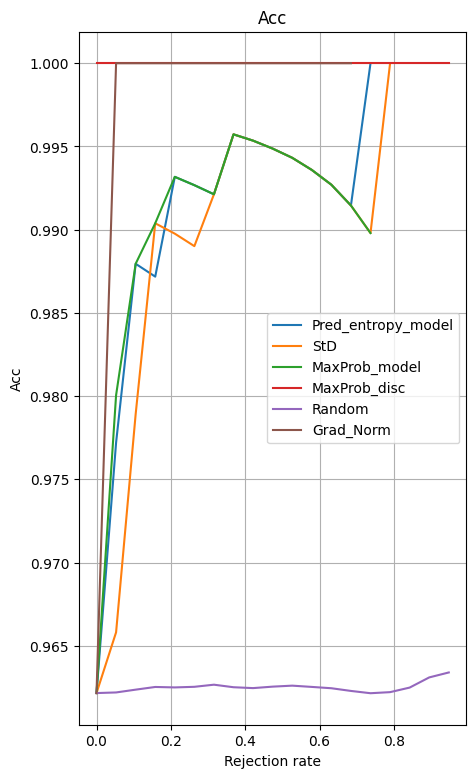

In [ ]:
plt.figure(figsize=(17, 9))

for i, (metric_name, curves_dict) in enumerate(dict_curves.items()):
    
    plt.subplot(1, 3, i+1)

    for label, metric in curves_dict.items():
        if 'Iter' in label:
            plt.plot(rejection_rates[0:len(metric)], metric, label=label, linewidth = 3, linestyle='--')
        else:
            plt.plot(rejection_rates[0:len(metric)], metric, label=label)
    plt.title(metric_name)
    plt.xlabel('Rejection rate')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()

plt.show()